**Sentiment Analysis very used topic in nowadays. Consider a very large company, this company will get thousands review about their products everyday. Company should automate this with basic deep learning algorithm instead of employing many people for this job. Another example politicans. Politicans review their moves with sentiment analysis by looking social media platforms. The biggest example of this [Donald Trump on US Elections](https://voxeu.org/article/how-twitter-affected-2016-presidential-election)**

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [ ]:
data

In [ ]:
X = data["review"]
y = data["sentiment"]

# 1. Remove Non Alphabetic Characters

In [ ]:
X.shape, y.shape

In [ ]:
X[0][:250]

**We will remove non alphabetic characters, best way to do that is [regex](https://docs.python.org/3/library/re.html) method**

In [ ]:
import re
for i in range(X.shape[0]):
    X[i] = re.sub('[^A-Za-z]', ' ', X[i])

In [ ]:
X[0][:250]

# 2.Stemming

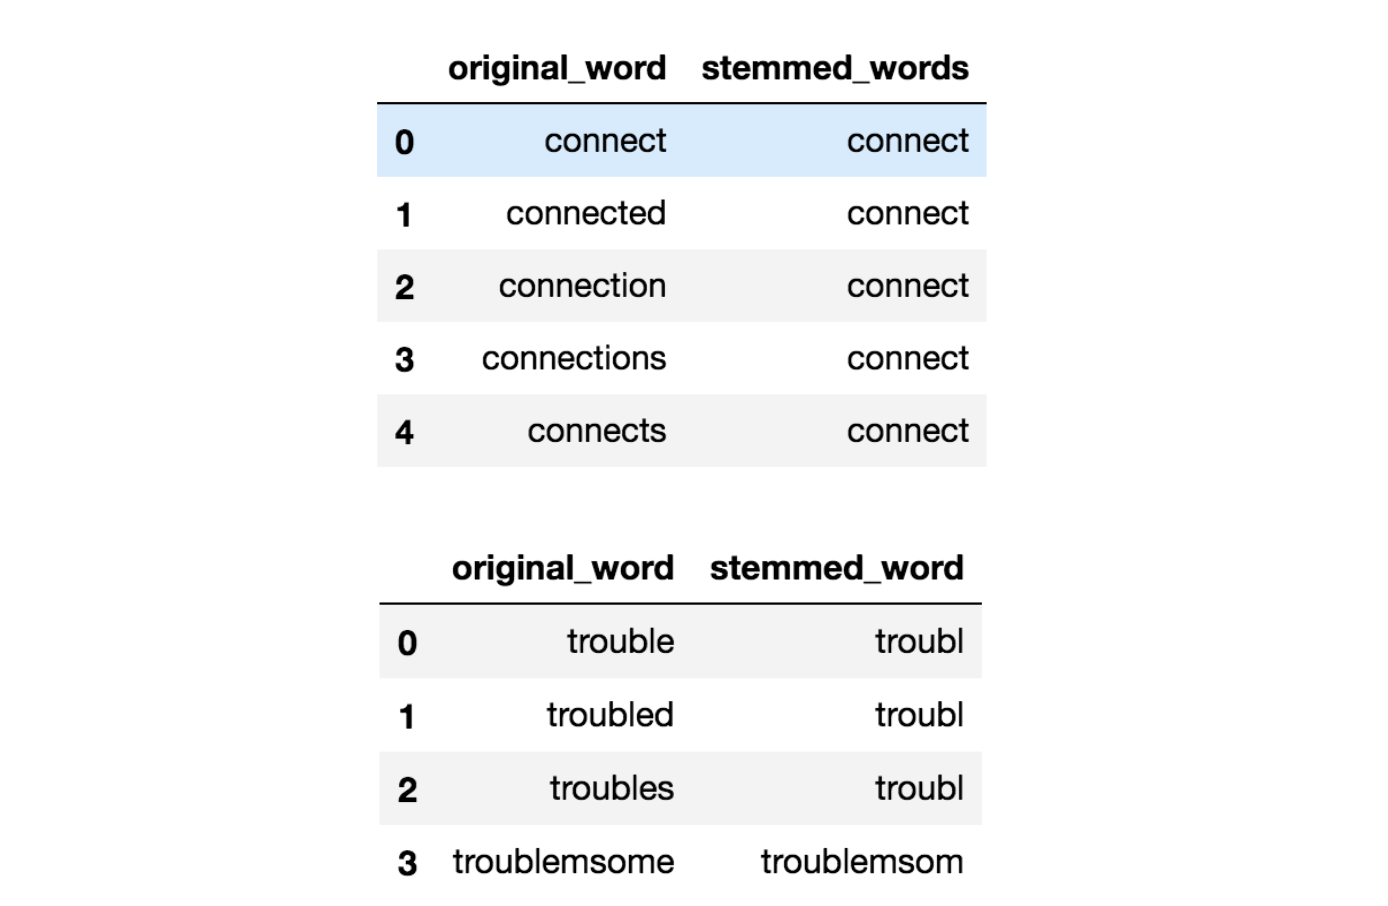

**As you can see above in stemming operation we extract root of the word. We will get rid of prefixes and suffixes. Before stemming operation we need to seperate sentences to words.**

In [ ]:
for i in range(X.shape[0]):
    X[i] = X[i].split(" ")
    X[i] = [w for w in X[i] if w != ""]

In [ ]:
import nltk
nltk.download("punkt")

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
for i in range(X.shape[0]):
    X[i] = [stemmer.stem(w) for w in X[i]]

In [ ]:
" ".join(X[0][:40])

**Make every word lower case**

In [ ]:
for i in range(X.shape[0]):
    X[i] = [w.lower() for w in X[i]]

In [ ]:
" ".join(X[0][:40])

## 3.Remove Stop Words

In [ ]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords_ = stopwords.words("english")
",".join(stopwords_)

**By removing stop words we remove the low-level information from our text in order to give more focus to the important information. This words does not effect sentiment of the review.**

In [ ]:
for i in range(X.shape[0]):
    X[i] = [w for w in X[i] if w not in stopwords_]

In [ ]:
" ".join(X[0][:40])

## 4.Create Bag of Words for every review

**Sort words by frequency**

In [ ]:
word_dict = {}
for i in range(X.shape[0]):
    for w in X[i]:
        if w not in word_dict:
            word_dict[w] = 0
        word_dict[w] += 1
word_dict = sorted(word_dict.items(), key= lambda x : x[1], reverse=True)

# print most used 20 words

cnt = 0
for k,v in word_dict:
    cnt += 1
    if cnt == 21:
        break
    print(k,v)

**Print Word Cloud**

In [ ]:
text = ""
cnt = 0
for k,v in word_dict:
    cnt += 1
    if cnt == 5000:
        break
    for i in range(v):
        text += k + " "

import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plot_cloud(wordcloud)

**We will get 5000 most used words and store another dictionary**

In [ ]:
most_used_words = {}
cnt = 0
index = 0
for word, freq in word_dict:
    most_used_words[word] = index
    index += 1
    cnt += 1
    if cnt == 5000:
        break
list(most_used_words.items())[0:10]

**We will remove words not in most used word dict and we change every word with its index**

In [ ]:
X_train = []
for i in range(X.shape[0]):
    list_ = []
    for w in X[i]:
        try:
            list_.append(most_used_words[w])
        except:
            pass
    X_train.append(list_)
for i in X_train[0]:
    print(i, end=" ")

## 5.Train with RNN

**Get average length of lists**

In [ ]:
leng = 0
for i in range(len(X_train)):
    leng += len(X_train[i])
leng / len(X_train)

In [ ]:
X_train = np.array(X_train)

**Average length of sentences 119, we can use 125. We will constrain size of every sentence to 125. Algorithm will complete smaller sentences to 125 by adding zeros.**

In [ ]:
import tensorflow as tf
from tensorflow import keras
X_train = keras.preprocessing.sequence.pad_sequences(X_train, 125)

In [ ]:
print(X_train.shape)
for i in X_train[0]:
    print(i, end=" ")

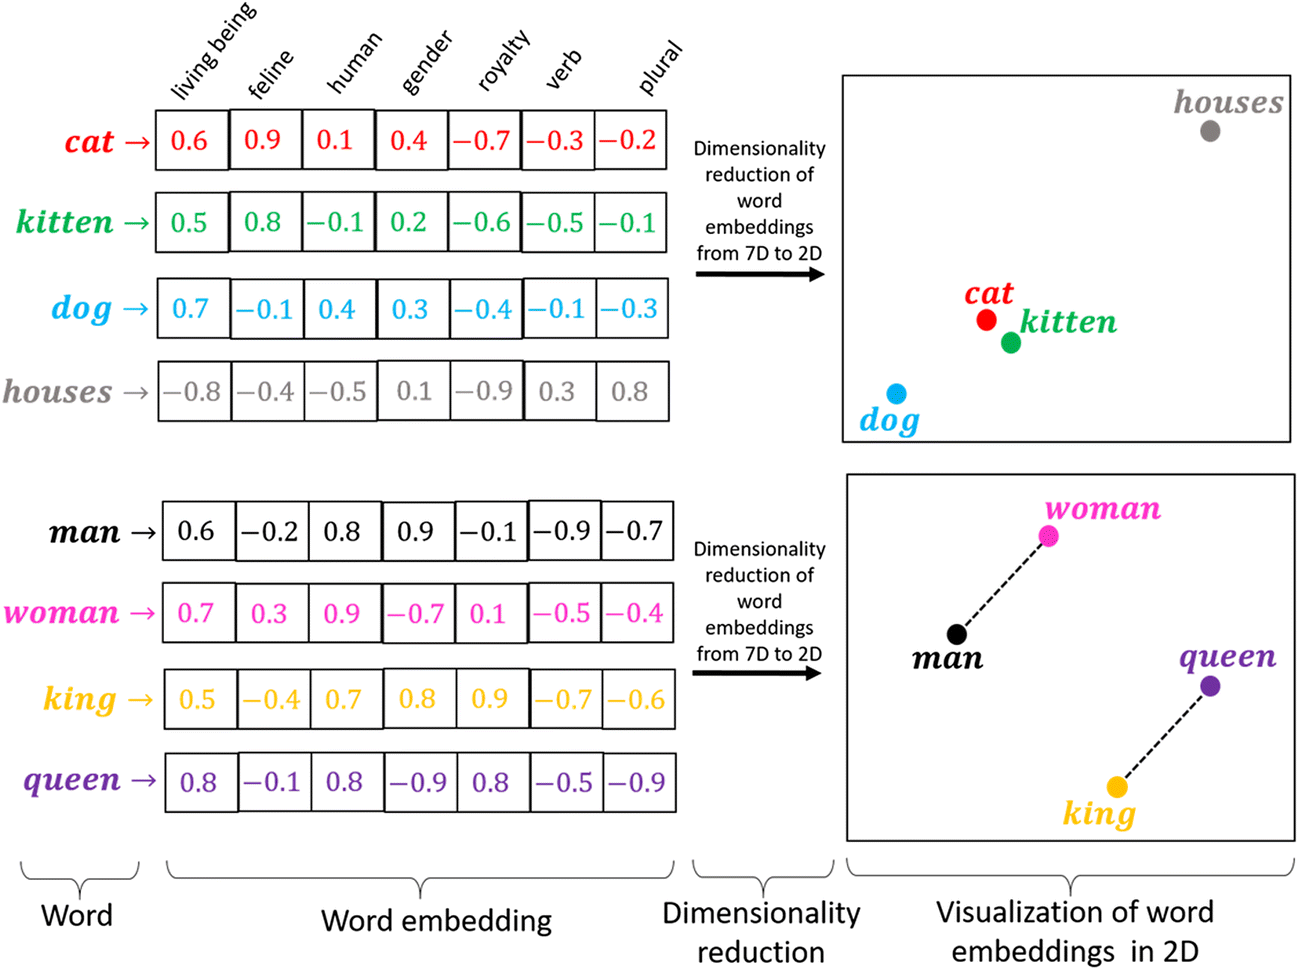

**We will use embedding algorithm in our RNN deep learning model. Word embeddings are commonly used in many Natural Language Processing (NLP) tasks because they are found to be useful representations of words and often lead to better performance in the various tasks performed**

**We will prepare our labels for deep learning algorithm**

In [ ]:
y[0:5]

In [ ]:
y = [1 if i=="positive" else 0 for i in y]
y[0:5]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, np.array(y), test_size = 0.2)

In [ ]:
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(5000, 32, input_length=125))
lstm_model.add(keras.layers.LSTM(100, return_sequences = True))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.LSTM(100, return_sequences = False))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer="rmsprop", loss=keras.losses.binary_crossentropy, metrics="accuracy")

In [ ]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)
mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data = (X_test, y_test),
                   callbacks = [learning_rate_reduction, early_stopping, mcp_save])
plot_history(history)

In [ ]:
lstm_model.load_weights('.mdl_wts.hdf5')

In [ ]:
gru_model = keras.Sequential()
gru_model.add(keras.layers.Embedding(5000, 32, input_length=125))
gru_model.add(keras.layers.GRU(100, return_sequences = True, activation = "tanh"))
gru_model.add(keras.layers.Dropout(0.5))
gru_model.add(keras.layers.GRU(100, return_sequences = False, activation = "tanh"))
gru_model.add(keras.layers.Dropout(0.5))
gru_model.add(keras.layers.Dense(1, activation="sigmoid"))
gru_model.compile(optimizer="rmsprop", loss=keras.losses.binary_crossentropy, metrics="accuracy")

In [ ]:
history = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data = (X_test, y_test),
                   callbacks = [learning_rate_reduction, early_stopping, mcp_save])
plot_history(history)

In [ ]:
gru_model.load_weights('.mdl_wts.hdf5')

We will continue with GRU (Gated recurrent unit) model

In [ ]:
def predict(review):
    # remove non alphabetic characters
    review = re.sub('[^A-Za-z]', ' ', review) 
    
    # stemming
    review = review.split(" ")
    review = [w for w in review if w != ""]
    review = [stemmer.stem(w) for w in review]
    
    # remove stepwords
    review = [w for w in review if w not in stopwords_]
    
    # get bag of words
    list_ = []
    for w in review:
        try:
            list_.append(most_used_words[w])
        except:
            pass
    test = [list_]
    test = np.array(test)
    test = keras.preprocessing.sequence.pad_sequences(test, 125)
    pred = gru_model.predict(test)[0][0]
    print("Positive : ", pred)
    print("Negative : ", 1-pred)

**This dataset published in 2019. I will try model with reviews of Black Widow (2021)**

In [ ]:
negative_review = "Where to start???? Very cheap story,bad acting,cant understand other people reviews ,especially about Florence acting,she have so stubborn face exprecions,anoying voice overal. Sarcasm all the time through the movie and not funny at all in any moment. To much talking and almost none action. Avoid this at any stake,dont waste money in cinema."

In [ ]:
negative_review_2 = "VERY BAD SCRIPT first of all.There are sooooo many characters that I can hardly see Natasha. What the hell is wrong with you people ?! A lot of CGI which sucks.Unrealistic fight scenes in the middle of the town where pedestrians are not reacting........really?Not to mention the fake Russian accent of the actors :))))) Thank God i didn't have to pay to see such a bad movie.You failed."

In [ ]:
positive_review = "Johansson and Pugh knock this movie completely out of the park. Their action is gripping, their grief and trauma are convincing & heart-wrenching, and their chemistry is outstanding - the best 'buddy' duo in the MCU, I'd say (outshining Falcon & the Winter Soldier, who I like, et.al.) An added plus is that they are both gorgeous.The story is well-written. Natasha has a chance to settle scores and quiet demons from her past, as well as reunite with those she thought she'd lost. Underneath it all is a sobering fictional example of the all-too-real international problem of human trafficking.If you love Marvel movies, you'll have a blast watching this one (unless, of course, you are a misogynist like some reviewers I have read on this site.)"

In [ ]:
positive_review_2 = "This was really fun. Frances Pugh was SUPPOSED to carry the movie as she is in the new Hawkeye series this year. It was fun to see one of the human superheros in action, no special powers. It is like Jason Bourne which is great. I'm glad we didn't spend time watching her be tortured as a child. Very exciting and heartwarming at the same time. No avenger cameos to detract from the film. It's fun and different."

In [ ]:
predict(negative_review)

In [ ]:
predict(negative_review_2)

In [ ]:
predict(positive_review)

In [ ]:
predict(positive_review_2)